Dr Helen Lu Copyright (c) 2022

I love the Simpsons. I found this source ([Kaggle source](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook#Training-the-modelhttps://)) on Kaggle and modified the examples for the class to get a feel of the Word2Vec Model.
If you have not watched the animation sticom, here is an introduction ([Wikepedia](https://en.wikipedia.org/wiki/The_Simpsons)).

In this lab session, we use the dialogues in the Simpsons to train word embeddings. 


# **1. Import Python libraries and upload the csv file containing dialogues from the Simpsons.**

We use the [Gensim](https://radimrehurek.com/gensim/intro.html#what-is-gensim) library to illustrate the Word2Vec function. 

In [48]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [49]:
# use the latest Gensim library
!pip install  --upgrade gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
# upload file "simpsons_script_lines.csv" 
# takes five to eight minues
from google.colab import files
t = time()
uploaded = files.upload()
print('Time to upload the data: {} mins'.format(round((time() - t) / 60, 2)))

Saving simpsons_script_lines.csv to simpsons_script_lines (1).csv
Time to upload the data: 8.83 mins


In [51]:
uploaded.keys()

dict_keys(['simpsons_script_lines.csv'])

In [52]:
import os
file_name = list(uploaded.keys())[0]
file_name 

'simpsons_script_lines.csv'

In [53]:
#read the csv file into a Pandas dataframe
df=pd.read_csv(file_name, error_bad_lines=False)
print("shape of dataframe:", df.shape)
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'


shape of dataframe: (158248, 13)


b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\nSkipping line 154089: expected 13 fields, saw 23\nSkipping line 154165: expected 13 fields, saw 21\nSkipping line 156872: expected 13 fields, saw 20\n'
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [54]:
# obtain the charater name and words columns into a new dataframe "data"
data = df[['raw_character_text','spoken_words']]
data.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [55]:
#check the number of empty cells
data.isnull().sum()

raw_character_text    17522
spoken_words          26159
dtype: int64

In [56]:
# remove rows with missing values (some rows are locations without dialogues)
data = data.dropna().reset_index(drop=True)
data.isnull().sum()


raw_character_text    0
spoken_words          0
dtype: int64

# **2. Pre-processing**
## **2.1. Lemmatrisation and reomving stop words and non-alphabetic characters**

In [57]:
nlp = spacy.load("en_core_web_sm") 

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [58]:
# Removes non-alphabetic characters in dialogues:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data['spoken_words'])

In [59]:
# run the pre-processing pipeline: takes about 2 mins
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 4.1 mins


In [60]:
#Put the results in a DataFrame to remove missing values and duplicates:
# compare the cleaned text with the original normalized_text
data_clean = pd.DataFrame({'clean': txt})
data_clean = data_clean.dropna().drop_duplicates()
print("The shape of cleaned data:",data_clean.shape)
data_clean.head()

The shape of cleaned data: (86142, 1)


,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide


## **2.2. Use Gensim Phrases package to automatically detect common phrases (n-grams) from sentences.**

In [62]:
from gensim.models.phrases import Phrases

# Define English connector words
english_connectors = {'and', 'or', 'but', 'because', 'that'}


In [63]:
sent = [row.split() for row in data_clean['clean']]

In [64]:
phrase_model = Phrases(sent, min_count=30, progress_per=10000, common_terms=english_connectors)

In [65]:
# examine an original sentence and sentence after applying the phrase model
print("The first sentence:", sent[39])
phrase_model[sent[39]]

The first sentence: ['homer', 'allow', 'hurt', 'feeling', 'right', 'little', 'girl', 'upstairs', 'need', 'confidence', 'father', 'shake', 'little', 'girl', 'happy', 'faith', 'daddy']


/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  start_token, in_between = word, []  # treat word as both end of a phrase AND beginning of another


['homer',
 'allow',
 'hurt',
 'feeling',
 'right',
 'little_girl',
 'upstairs',
 'need',
 'confidence',
 'father',
 'shake',
 'little_girl',
 'happy',
 'faith',
 'daddy']

In [66]:
sentences = phrase_model[sent]

In [67]:
type(sentences)

gensim.interfaces.TransformedCorpus

In [68]:
# Most frequent tokens
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29745

In [69]:
# most frequently used tokens
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

# **3. Train the Word2Vec model**

In [70]:
import multiprocessing
from gensim.models import Word2Vec

## **3.1. Set the parameters:**
 

*   min_count = int (2, 100). Ignores all words with total absolute frequency lower than this. 
*   window = int (2, 10). The maximum distance between the current and predicted word window within a sentence. E.g. window words on the left and window words on the left of our target.
*   vector_size = int (50, 300). Dimensionality of the feature vectors.
*   sample = float (0, 1e-5). The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. 
*   alpha = float (0.01, 0.05). The initial learning rate
*   min_alpha= float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
*   negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
*  workers = int - Use these many worker threads to train the model (=faster training with multicore machines)




In [71]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5)

### **3.2. Building the Vocabulary Table:**
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [72]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.43 mins


## **3.3. Training of the model:**
Parameters of the training:

total_examples = int - Count of sentences;
epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [73]:
# take about 1 min
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 2.73 mins


# **4. Explore the model**
## **4.1 Similar words (or, words tend to co-occur nearby)**

Let's see what we get for the show's main character: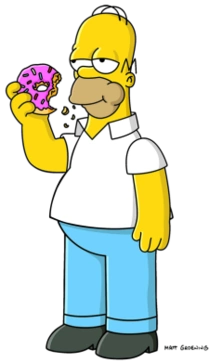

This dataset is the Simpson's lines of dialogue. The words similar to "homer" are what others often say about him.

In [74]:
w2v_model.wv.most_similar(positive=["homer"])

[('sorry', 0.8658036589622498),
 ('snuggle', 0.8575474619865417),
 ('sweetheart', 0.853425145149231),
 ('marge', 0.8468605279922485),
 ('nervous', 0.8410295248031616),
 ('talk', 0.8361460566520691),
 ('happen', 0.8339163064956665),
 ('drunk', 0.8338148593902588),
 ('gee', 0.8296716213226318),
 ('abe', 0.8271300792694092)]

What about Marge now?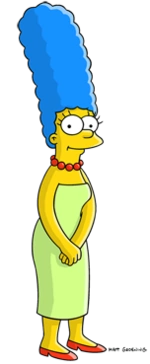

In [75]:
w2v_model.wv.most_similar(positive=["marge"])

[('married', 0.8642829060554504),
 ('have', 0.8608842492103577),
 ('sweetheart', 0.8595461845397949),
 ('homie', 0.8575971126556396),
 ('nervous', 0.8541725873947144),
 ('brunch', 0.8533011674880981),
 ('sorry', 0.8485091924667358),
 ('homer', 0.8468605279922485),
 ('pregnant', 0.8349610567092896),
 ('ned', 0.8344532251358032)]

In [76]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8968666791915894),
 ('milhouse', 0.8911504149436951),
 ('mom_dad', 0.8890137076377869),
 ('upset', 0.8875244855880737),
 ('mom', 0.8538144826889038),
 ('kid', 0.8514471650123596),
 ('snuggle', 0.8512928485870361),
 ('strangle', 0.8507128953933716),
 ('worried', 0.8474618196487427),
 ('grownup', 0.8456237316131592)]

In [77]:
w2v_model.wv.most_similar(positive=["lisa"])

[('bart', 0.8968666791915894),
 ('upset', 0.8572795391082764),
 ('sweetie', 0.8558251261711121),
 ('surprised', 0.843355655670166),
 ('grownup', 0.8431472778320312),
 ('glad', 0.8398072719573975),
 ('tell_truth', 0.8386023640632629),
 ('nervous', 0.8358112573623657),
 ('milhouse', 0.8323761224746704),
 ('jealous', 0.8323255777359009)]

## **4.2 Consine similarites**

Moe is the local tavern (Moe's) owner. Homer frequents this tarvern. Homer and Moe are more closely related than Moe and Bart (Bart does not go to the bar).

Lisa and "praise" are more requently associated than Bart and "praise".

Moe Szyslak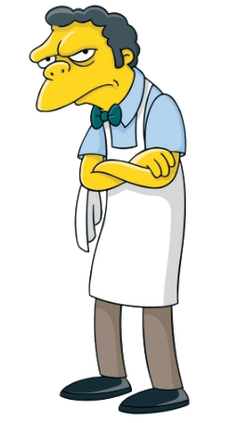

Bart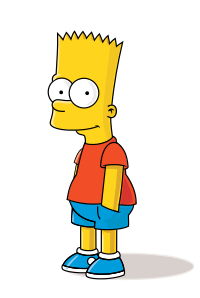

Lisa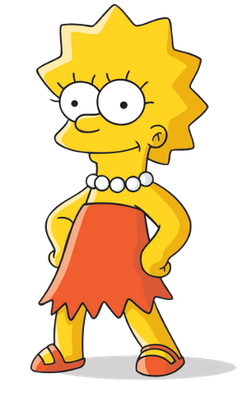

In [78]:
w2v_model.wv.similarity("moe", 'tavern')

0.8959169

In [79]:
w2v_model.wv.similarity("homer", 'tavern')

0.5699939

In [80]:
w2v_model.wv.similarity("bart", 'tavern')

0.2862487

In [81]:
print("Bart consine with mad:", w2v_model.wv.similarity("bart", 'mad'), "Bart consine with sweet", w2v_model.wv.similarity("bart", 'sweet'))
print("Lisa consine with mad:", w2v_model.wv.similarity("lisa", 'mad'), "Lisa consine with sweet", w2v_model.wv.similarity("lisa", 'sweet'))

Bart consine with mad: 0.787106 Bart consine with sweet 0.46048576
Lisa consine with mad: 0.75046057 Lisa consine with sweet 0.4793039


## **4.3. Analogies: Finding Words with Similar Distance**

Ned Flander is the good-natured next-door neighoour to the Simpson family and generally loathed by Homer Simpson.  A scrupulous and devout evangelical Christian, he is among the friendliest and most compassionate of Springfield's residents and is generally considered a pillar of the Springfield community.

In [82]:
# Flander volunteers often, while Homer...
w2v_model.wv.most_similar(positive=["flander", "volunteer"], negative=["homer"], topn=3)

[('fallout', 0.7342272400856018),
 ('christian', 0.7333425283432007),
 ('violate', 0.7287108898162842)]

In [83]:
# Maude is Ned Flander's wife and Marge is Homer's wife.
w2v_model.wv.most_similar(positive=["maude", "marge"], negative=["homer"], topn=3)

[('gosh', 0.7689553499221802),
 ('ned_flander', 0.748860239982605),
 ('catholic', 0.7386153340339661)]

In [84]:
w2v_model.wv.most_similar(positive=["bart", "lisa"], negative=["man"], topn=3)

[('mom', 0.7094486951828003),
 ('kid', 0.7057560682296753),
 ('milhouse', 0.7048013806343079)]

## **4.4 Odd-one-out**


In [85]:
# choose the one that does not belong to the list
# bart and milhouse are best friends; nelson is the school bully
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

/usr/local/lib/python3.8/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vector : numpy.array


'nelson'

In [86]:
# does Holmer get mentioned with his two sister-in-lawyers together often?
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'